# Yape 2019-2023 Analysis

Este informe fusiona análisis descriptivos fundamentales con técnicas avanzadas de exploración de datos para ofrecer una visión completa del ecosistema mediático de **Yape**.

---

In [20]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import glob
import os
from collections import Counter
import re

# Configuración Visual Premium
sns.set_theme(style="whitegrid", context="notebook", palette="viridis")
plt.rcParams["figure.figsize"] = (14, 7)
plt.rcParams["axes.titlesize"] = 16
plt.rcParams["axes.labelsize"] = 12

# Rutas
DATA_DIR_OLD = "../data"
DATA_DIR_NEW = "../data/raw"
OUTPUT_FILE = "../data/raw/Yape_19_23.csv"
TARGET_YEARS = [2019, 2020, 2021, 2022, 2023]

## 1. ETL & Data Unification Strategy
Proceso robusto de carga, estandarización y deduplicación.

In [ ]:
def load_and_standardize(path_pattern, label):
    files = glob.glob(path_pattern)
    dfs = []
    for f in files:
        if "gap" in f or "Yape_19_23" in f: continue
        try:
            # Robust Reading
            try:
                df = pd.read_csv(f)
            except:
                df = pd.read_csv(f, sep=';')
            
            # Standardize Columns
            rename_map = {
                'published_at': 'publish_date',
                'newspaper': 'domain',
                'plain_text': 'text',
                'content': 'text'
            }
            df.rename(columns=rename_map, inplace=True)
            
            # Normalize Date
            df['publish_date'] = pd.to_datetime(df['publish_date'], errors='coerce', utc=True)
            df['year'] = df['publish_date'].dt.year
            
            # Normalize Relevance
            if 'relevance_score' not in df.columns:
                df['relevance_score'] = np.nan
            else:
                df['relevance_score'] = pd.to_numeric(df['relevance_score'], errors='coerce')
            
            # Filling missing keywords
            if 'keyword' not in df.columns:
                df['keyword'] = 'Unknown'
            
            df['source_dataset'] = label
            dfs.append(df)
        except Exception as e:
            pass
            
    if not dfs: return pd.DataFrame()
    return pd.concat(dfs, ignore_index=True)

# 1. Load Datasets
df_old = load_and_standardize(os.path.join(DATA_DIR_OLD, "yape_*.csv"), "Legacy")
df_new = load_and_standardize(os.path.join(DATA_DIR_NEW, "yape_*.csv"), "Phase1")

# 2. Filter Years
df_old = df_old[df_old['year'].isin(TARGET_YEARS)]
df_new = df_new[df_new['year'].isin(TARGET_YEARS)]

# 3. Strategic Merge (Priority to Phase 1)
full_df = pd.concat([df_new, df_old], ignore_index=True)

# 4. Deduplication by URL
full_df['url_clean'] = full_df['url'].str.strip()
full_df.drop_duplicates(subset=['url_clean'], keep='first', inplace=True)
full_df.drop(columns=['url_clean'], inplace=True)

# 5. Save
full_df.to_csv(OUTPUT_FILE, index=False)
print(f" Dataset Unificado Generado: {len(full_df)} registros.")
print(f"   - Legacy Contribution: {len(full_df[full_df['source_dataset']=='Legacy'])}")
print(f"   - Phase1 Contribution: {len(full_df[full_df['source_dataset']=='Phase1'])}")

✅ Dataset Unificado Generado: 613 registros.
   - Legacy Contribution: 21
   - Phase1 Contribution: 592


## 2. Análisis Temporal (Volumen y Tendencias)

/tmp/ipykernel_127372/1079143216.py:1: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  full_df['month'] = full_df['publish_date'].dt.to_period('M')
/tmp/ipykernel_127372/1079143216.py:15: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_xticklabels(monthly_stats['month_str'], rotation=90)


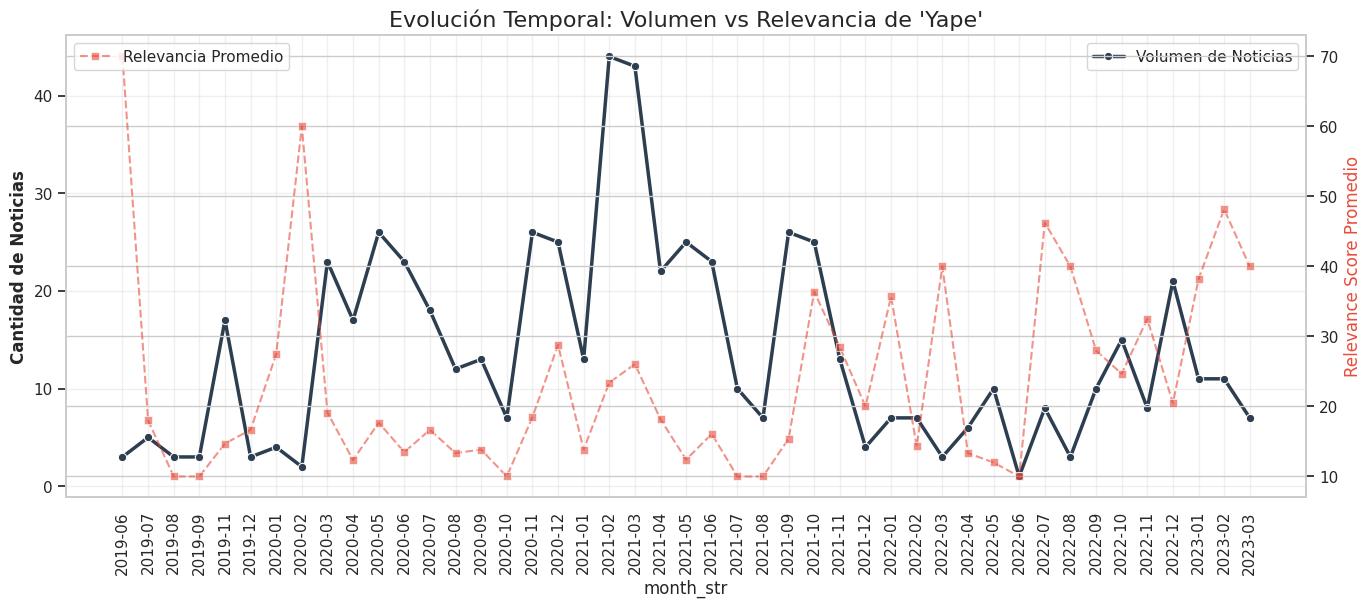

In [22]:
full_df['month'] = full_df['publish_date'].dt.to_period('M')

monthly_stats = full_df.groupby('month').agg(
    count=('url', 'size'),
    avg_relevance=('relevance_score', 'mean')
).reset_index()
monthly_stats['month_str'] = monthly_stats['month'].astype(str)

fig, ax1 = plt.subplots(figsize=(16, 6))

# Volume Plot
sns.lineplot(data=monthly_stats, x='month_str', y='count', ax=ax1, 
             marker='o', linewidth=2.5, color='#2c3e50', label='Volumen de Noticias')
ax1.set_ylabel("Cantidad de Noticias", fontsize=12, fontweight='bold')
ax1.set_xticklabels(monthly_stats['month_str'], rotation=90)
ax1.grid(True, alpha=0.3)

# Relevance Trend (Optional Overlay)
ax2 = ax1.twinx()
sns.lineplot(data=monthly_stats, x='month_str', y='avg_relevance', ax=ax2, 
             marker='s', linestyle='--', color='#e74c3c', label='Relevancia Promedio', alpha=0.6)
ax2.set_ylabel("Relevance Score Promedio", color='#e74c3c')

plt.title("Evolución Temporal: Volumen vs Relevancia de 'Yape'", fontsize=16)
plt.legend(loc='upper left')
plt.show()

## 3. Análisis de Fuentes (Top Dominios)
¿Qué medios están cubriendo más activamente el fenómeno Yape?

/tmp/ipykernel_127372/662070254.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_domains.values, y=top_domains.index, palette="mako")


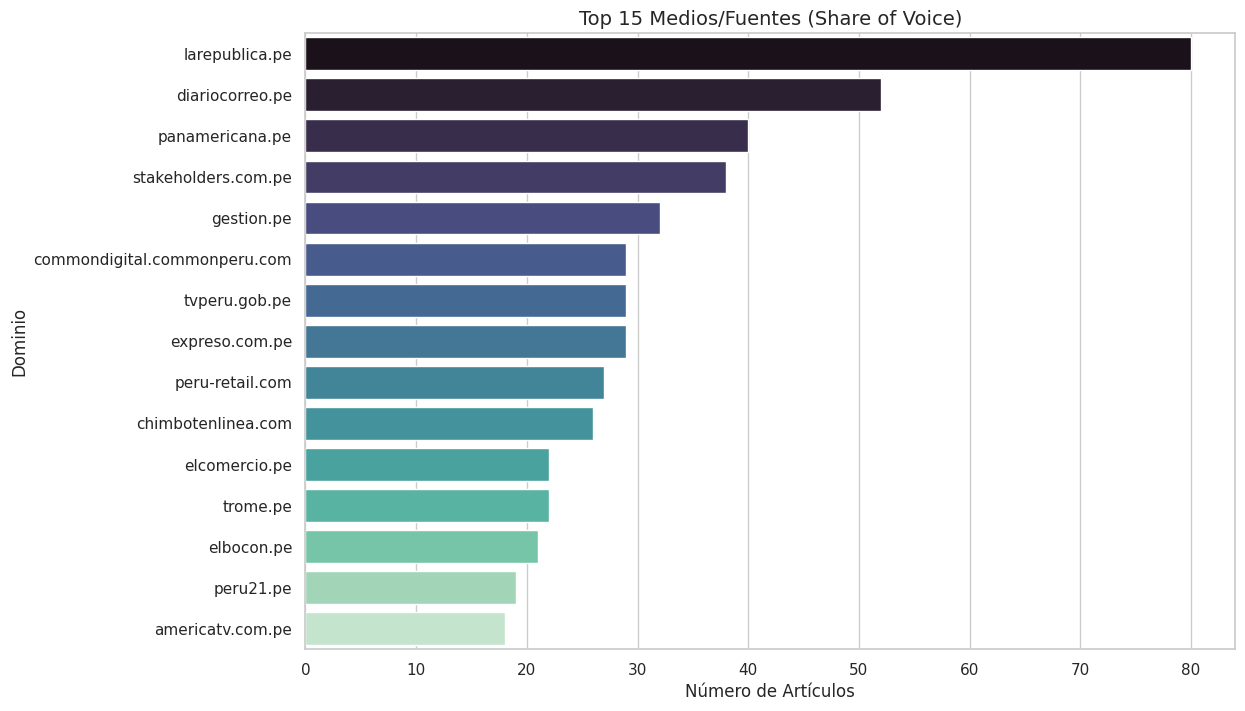

,Domain,Share
0,larepublica.pe,13.05%
1,diariocorreo.pe,8.48%
2,panamericana.pe,6.53%
3,stakeholders.com.pe,6.2%
4,gestion.pe,5.22%
5,commondigital.commonperu.com,4.73%
6,tvperu.gob.pe,4.73%
7,expreso.com.pe,4.73%
8,peru-retail.com,4.4%
9,chimbotenlinea.com,4.24%


In [23]:
top_domains = full_df['domain'].value_counts().head(15)

plt.figure(figsize=(12, 8))
sns.barplot(x=top_domains.values, y=top_domains.index, palette="mako")
plt.title("Top 15 Medios/Fuentes (Share of Voice)", fontsize=14)
plt.xlabel("Número de Artículos")
plt.ylabel("Dominio")
plt.show()

# Share of Voice table
domain_share = full_df['domain'].value_counts(normalize=True).head(10).reset_index()
domain_share.columns = ['Domain', 'Share']
domain_share['Share'] = (domain_share['Share'] * 100).round(2).astype(str) + '%'
domain_share

## 4. Keyword Insights
Desglose de los términos específicos de búsqueda.

/tmp/ipykernel_127372/3874990743.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=kw_counts.values, y=kw_counts.index, palette="rocket")


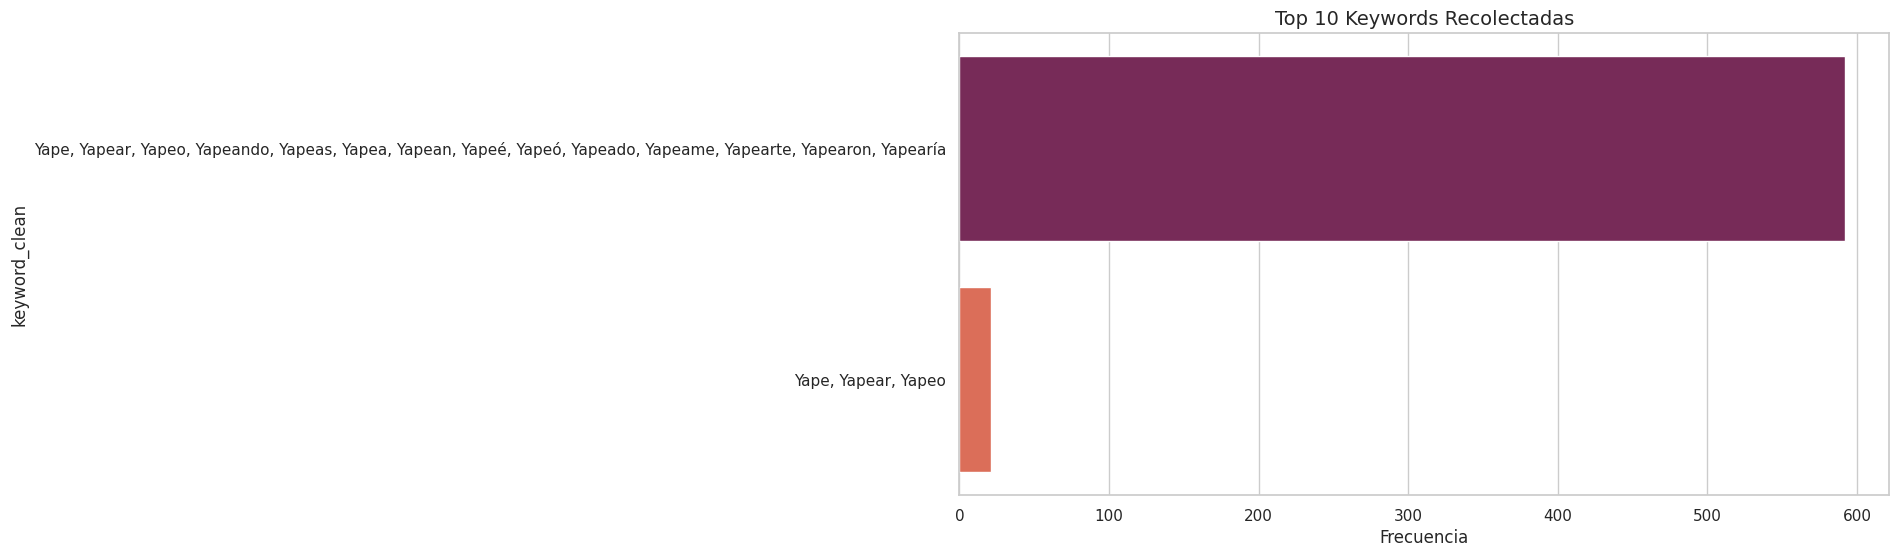

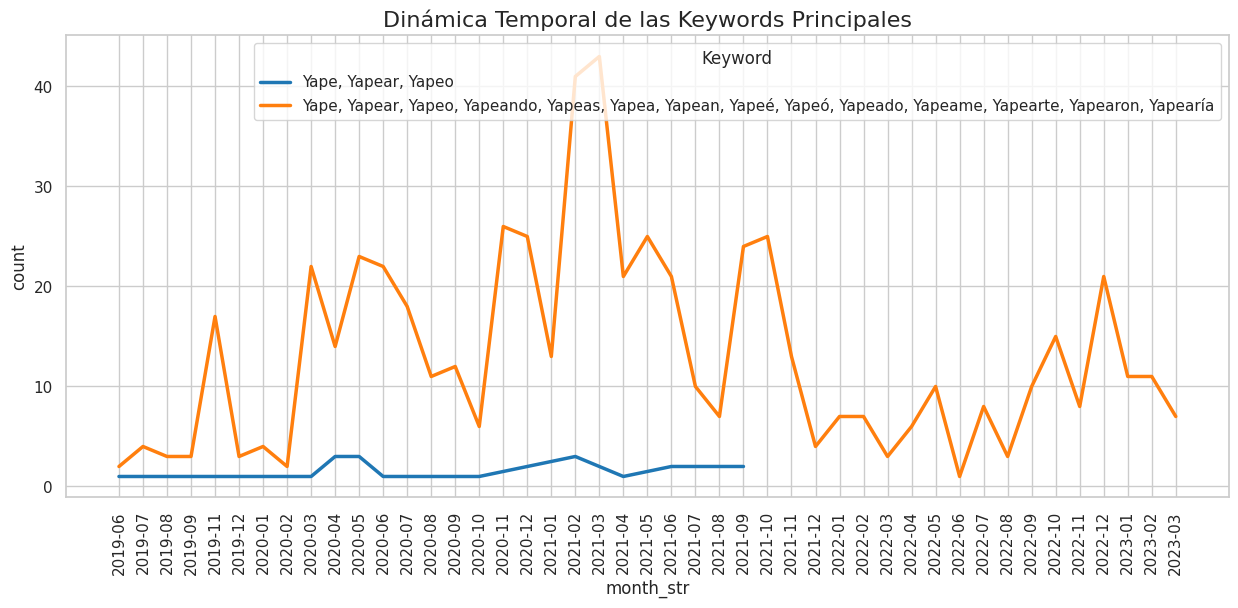

In [24]:
# Limpieza de keywords
def clean_keyword(k):
    if not isinstance(k, str): return "Unknown"
    k = k.replace("[", "").replace("]", "").replace("'", "").replace('"', '')
    return k.strip()

full_df['keyword_clean'] = full_df['keyword'].apply(clean_keyword)

# 1. Keyword Frequency Bar Chart
kw_counts = full_df['keyword_clean'].value_counts().head(10)

plt.figure(figsize=(12, 6))
sns.barplot(x=kw_counts.values, y=kw_counts.index, palette="rocket")
plt.title("Top 10 Keywords Recolectadas", fontsize=14)
plt.xlabel("Frecuencia")
plt.show()

# 2. Keyword Evolution Trend
kw_monthly = full_df.groupby(['month', 'keyword_clean']).size().reset_index(name='count')
kw_monthly['month_str'] = kw_monthly['month'].astype(str)
top5_kws = kw_counts.index[:5]
kw_monthly_top = kw_monthly[kw_monthly['keyword_clean'].isin(top5_kws)]

plt.figure(figsize=(15, 6))
sns.lineplot(data=kw_monthly_top, x='month_str', y='count', hue='keyword_clean', 
             palette="tab10", linewidth=2.5)
plt.xticks(rotation=90)
plt.title("Dinámica Temporal de las Keywords Principales")
plt.legend(title="Keyword")
plt.show()

## 5. Análisis de Contenido y Calidad (Scores)
Evaluación de la longitud del texto y su relación con el score de relevancia.

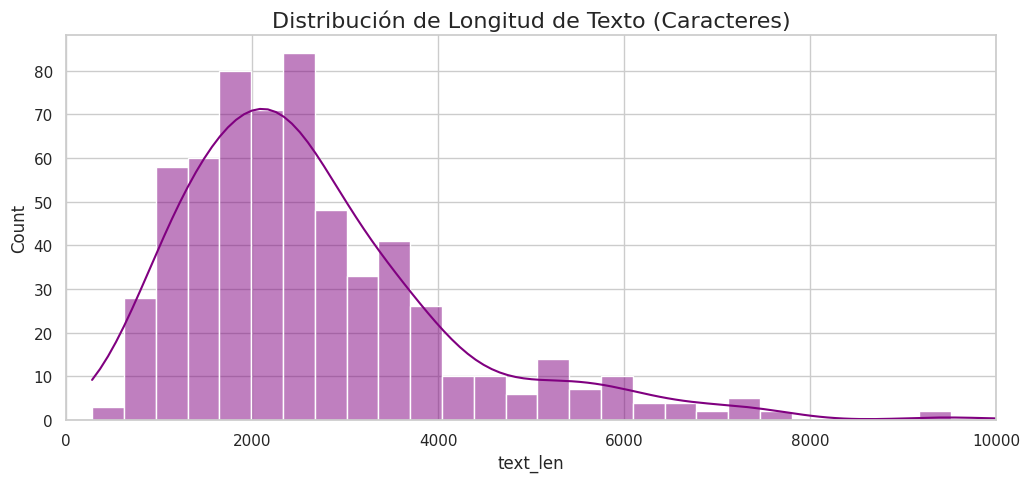

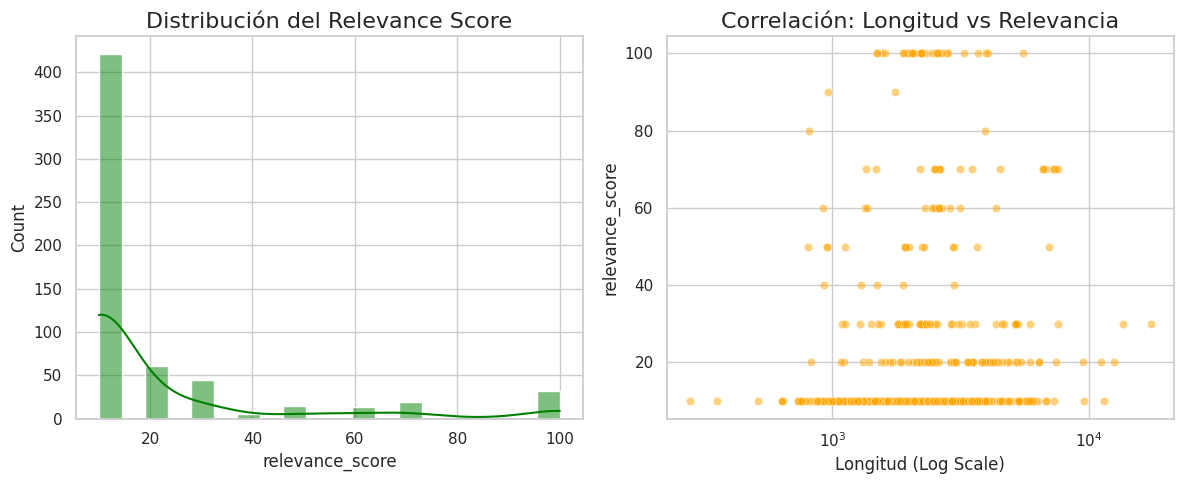

In [25]:
# Pre-calculo de longitud
full_df['text_len'] = full_df['text'].fillna('').astype(str).apply(len)

# 1. Histograma de Longitud
plt.figure(figsize=(12, 5))
sns.histplot(full_df['text_len'], bins=50, kde=True, color='purple')
plt.title("Distribución de Longitud de Texto (Caracteres)")
plt.xlim(0, 10000)
plt.show()

# 2. Relevance Score Dist & Correlation
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
sns.histplot(full_df['relevance_score'], bins=20, kde=True, color='green')
plt.title("Distribución del Relevance Score")

plt.subplot(1, 2, 2)
sns.scatterplot(data=full_df, x='text_len', y='relevance_score', alpha=0.5, color='orange')
plt.title("Correlación: Longitud vs Relevancia")
plt.xscale('log')
plt.xlabel("Longitud (Log Scale)")

plt.tight_layout()
plt.show()

## 6. Contexto Semántico (Bigramas)
Análisis de términos frecuentes que acompañan a la entidad principal.

Generando Contexto (Bigramas) frecuentes...


/tmp/ipykernel_127372/898932940.py:31: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=bg_counts, y=bg_labels, palette="cool")


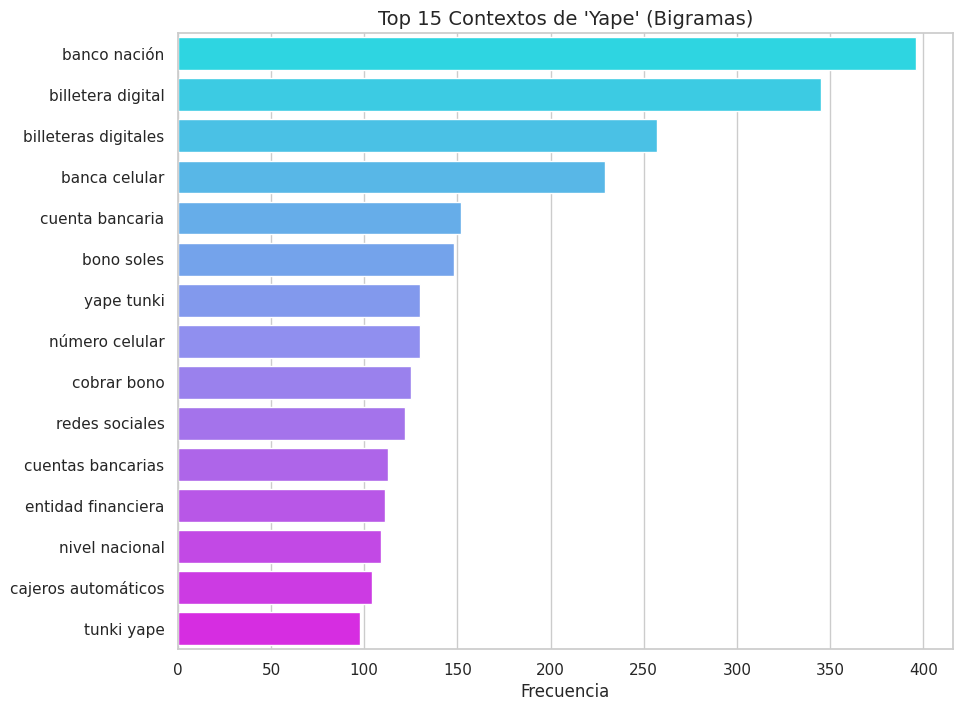

In [26]:
def generate_ngrams(text_series, n=2, top_k=15):
    words_list = []
    # Stopwords básicas en español
    stop_words = set(['de', 'la', 'el', 'en', 'y', 'a', 'los', 'del', 'se', 'las', 'por', 'un', 'una', 'con', 'no', 'su', 'es', 'al', 'lo', 'como', 'más', 'pero', 'sus', 'le', 'ya', 'o', 'este', 'sí', 'porque', 'esta', 'entre', 'cuando', 'muy', 'sin', 'sobre', 'también', 'me', 'hasta', 'desde', 'nos', 'durante', 'uno', 'ni', 'contra', 'ese', 'eso', 'mí', 'qué', 'otro', 'él', 'cual', 'poco', 'ella', 'estar', 'estos', 'algunos', 'algo', 'nosotros', 'mi', 'mis', 'tú', 'te', 'ti', 'tu', 'tus', 'ellas', 'nosotras', 'vosotros', 'vosotras', 'os', 'mío', 'mía', 'míos', 'mías', 'tuyo', 'tuya', 'tuyos', 'tuyas', 'suyo', 'suya', 'suyos', 'suyas', 'nuestro', 'nuestra', 'nuestros', 'nuestras', 'vuestro', 'vuestra', 'vuestros', 'vuestras', 'esos', 'esas', 'estoy', 'estás', 'está', 'estamos', 'estáis', 'están', 'esté', 'estés', 'estemos', 'estéis', 'estén', 'estaré', 'estarás', 'estará', 'estaremos', 'estaréis', 'estarán', 'estaría', 'estarías', 'estaríamos', 'estaríais', 'estarían', 'estaba', 'estabas', 'estábamos', 'estabais', 'estaban', 'estuve', 'estuviste', 'estuvo', 'estuvimos', 'estuvisteis', 'estuvieron', 'estuviera', 'estuvieras', 'estuviéramos', 'estuvierais', 'estuvieran', 'estuviese', 'estuvieses', 'estuviésemos', 'estuvieseis', 'estuviesen', 'estando', 'estado', 'estada', 'estados', 'estadas', 'estad', 'he', 'has', 'ha', 'hemos', 'habéis', 'han', 'haya', 'hayas', 'hayamos', 'hayáis', 'hayan', 'habré', 'habrás', 'habrá', 'habremos', 'habréis', 'habrán', 'habría', 'habrías', 'habríamos', 'habríais', 'habrían', 'había', 'habías', 'habíamos', 'habíais', 'habían', 'hube', 'hubiste', 'hubo', 'hubimos', 'hubisteis', 'hubieron', 'hubiera', 'hubieras', 'hubiéramos', 'hubierais', 'hubieran', 'hubiese', 'hubieses', 'hubiésemos', 'hubieseis', 'hubiesen', 'habiendo', 'habido', 'habida', 'habidos', 'habidas', 'soy', 'eres', 'es', 'somos', 'sois', 'son', 'sea', 'seas', 'seamos', 'seáis', 'sean', 'seré', 'serás', 'será', 'seremos', 'seréis', 'serán', 'sería', 'serías', 'seríamos', 'seríais', 'serían', 'era', 'eras', 'éramos', 'erais', 'eran', 'fui', 'fuiste', 'fue', 'fuimos', 'fuisteis', 'fueron', 'fuera', 'fueras', 'fuéramos', 'fuerais', 'fueran', 'fuese', 'fueses', 'fuésemos', 'fueseis', 'fuesen', 'sintiendo', 'sentido', 'sentida', 'sentidos', 'sentidas', 'siente', 'sentid', 'tengo', 'tienes', 'tiene', 'tenemos', 'tenéis', 'tienen', 'tenga', 'tengas', 'tengamos', 'tengáis', 'tengan', 'tendré', 'tendrás', 'tendrá', 'tendremos', 'tendréis', 'tendrán', 'tendría', 'tendrías', 'tendríamos', 'tendríais', 'tendrían', 'tenía', 'tenías', 'teníamos', 'teníais', 'tenían', 'tuve', 'tuviste', 'tuvo', 'tuvimos', 'tuvisteis', 'tuvieron', 'tuviera', 'tuvieras', 'tuviéramos', 'tuvierais', 'tuvieran', 'tuviese', 'tuvieses', 'tuviésemos', 'tuvieseis', 'tuviesen', 'teniendo', 'tenido', 'tenida', 'tenidos', 'tenidas', 'tened', 'que', 'para'])
    
    for text in text_series.dropna():
        # Clean simple
        text = re.sub(r'[^\w\s]', '', text.lower())
        words = [w for w in text.split() if w not in stop_words and len(w) > 3]
        words_list.extend(words)
    
    # Create N-grams
    if n == 2:
        ngrams_list = zip(words_list, words_list[1:])
    elif n == 3:
        ngrams_list = zip(words_list, words_list[1:], words_list[2:])
    else:
        return []
        
    cnt = Counter(ngrams_list)
    return cnt.most_common(top_k)

print("Generando Contexto (Bigramas) frecuentes...")
bigrams = generate_ngrams(full_df['text'])

# Visualizar Bigramas
bg_labels = [f"{x[0]} {x[1]}" for x, y in bigrams]
bg_counts = [y for x, y in bigrams]

plt.figure(figsize=(10, 8))
sns.barplot(x=bg_counts, y=bg_labels, palette="cool")
plt.title("Top 15 Contextos de 'Yape' (Bigramas)", fontsize=14)
plt.xlabel("Frecuencia")
plt.show()